본 노트북은 [A Note on Using a Single Model: XGBoost](https://www.kaggle.com/code/ivoryrabbit/a-note-on-using-a-single-model-xgboost/notebook)의 내용을 기반으로 만들어졌습니다.

목차

- IMPORT
- 탐험적 데이터 분석
    1. 데이터 확인
    2. 이산수치 속성들 간의 상관관계
    3. 연속수치 속성들 간의 상관관계
    4. 가격 분포 확인
- 전처리
    1. Feature Engineering
    2. Log Scaling
    3. Label Encoding
- 학습
    1. Hyperparameter
    2. Validation
    3. Prediction
    4. Feature Importance
- 제출

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 분석 기본 도구
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# 통계 분석 도구
from scipy import stats

# 전처리 도구
from sklearn.preprocessing import LabelEncoder

# 학습 도구
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#import lightgbm as lgb
import xgboost as xgb

# 검증 도구
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import make_scorer
#from sklearn.metrics import mean_squared_error

# 경고문 무시(seaborn)
import warnings
warnings.filterwarnings('ignore')

## Data Load

In [7]:
ls ../input/2019-2nd-ml-month-with-kakr

ls: cannot access '../input/2019-2nd-ml-month-with-kakr': No such file or directory


In [8]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/aiffel/data/house pricing 2019/train.csv')

print(train.shape)
train.head()

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/aiffel/data/house pricing 2019/test.csv')

print(test.shape)
test.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

## EDA

### 1. Check Features

In [12]:
data = pd.merge(train, test, how='outer')

print(data.shape)
data.head()

(21503, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [13]:
# Check our columns
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

date 열을 year 와 month, 그리고 day로 나누기

In [14]:
data['year'] = data['date'].apply(lambda x:x[:4]).astype(int)
data['month'] = data['date'].apply(lambda x:x[4:6]).astype(int)
data['day'] = data['date'].apply(lambda x:x[6:8]).astype(int)

In [15]:
data['yr_built'].min()

1900

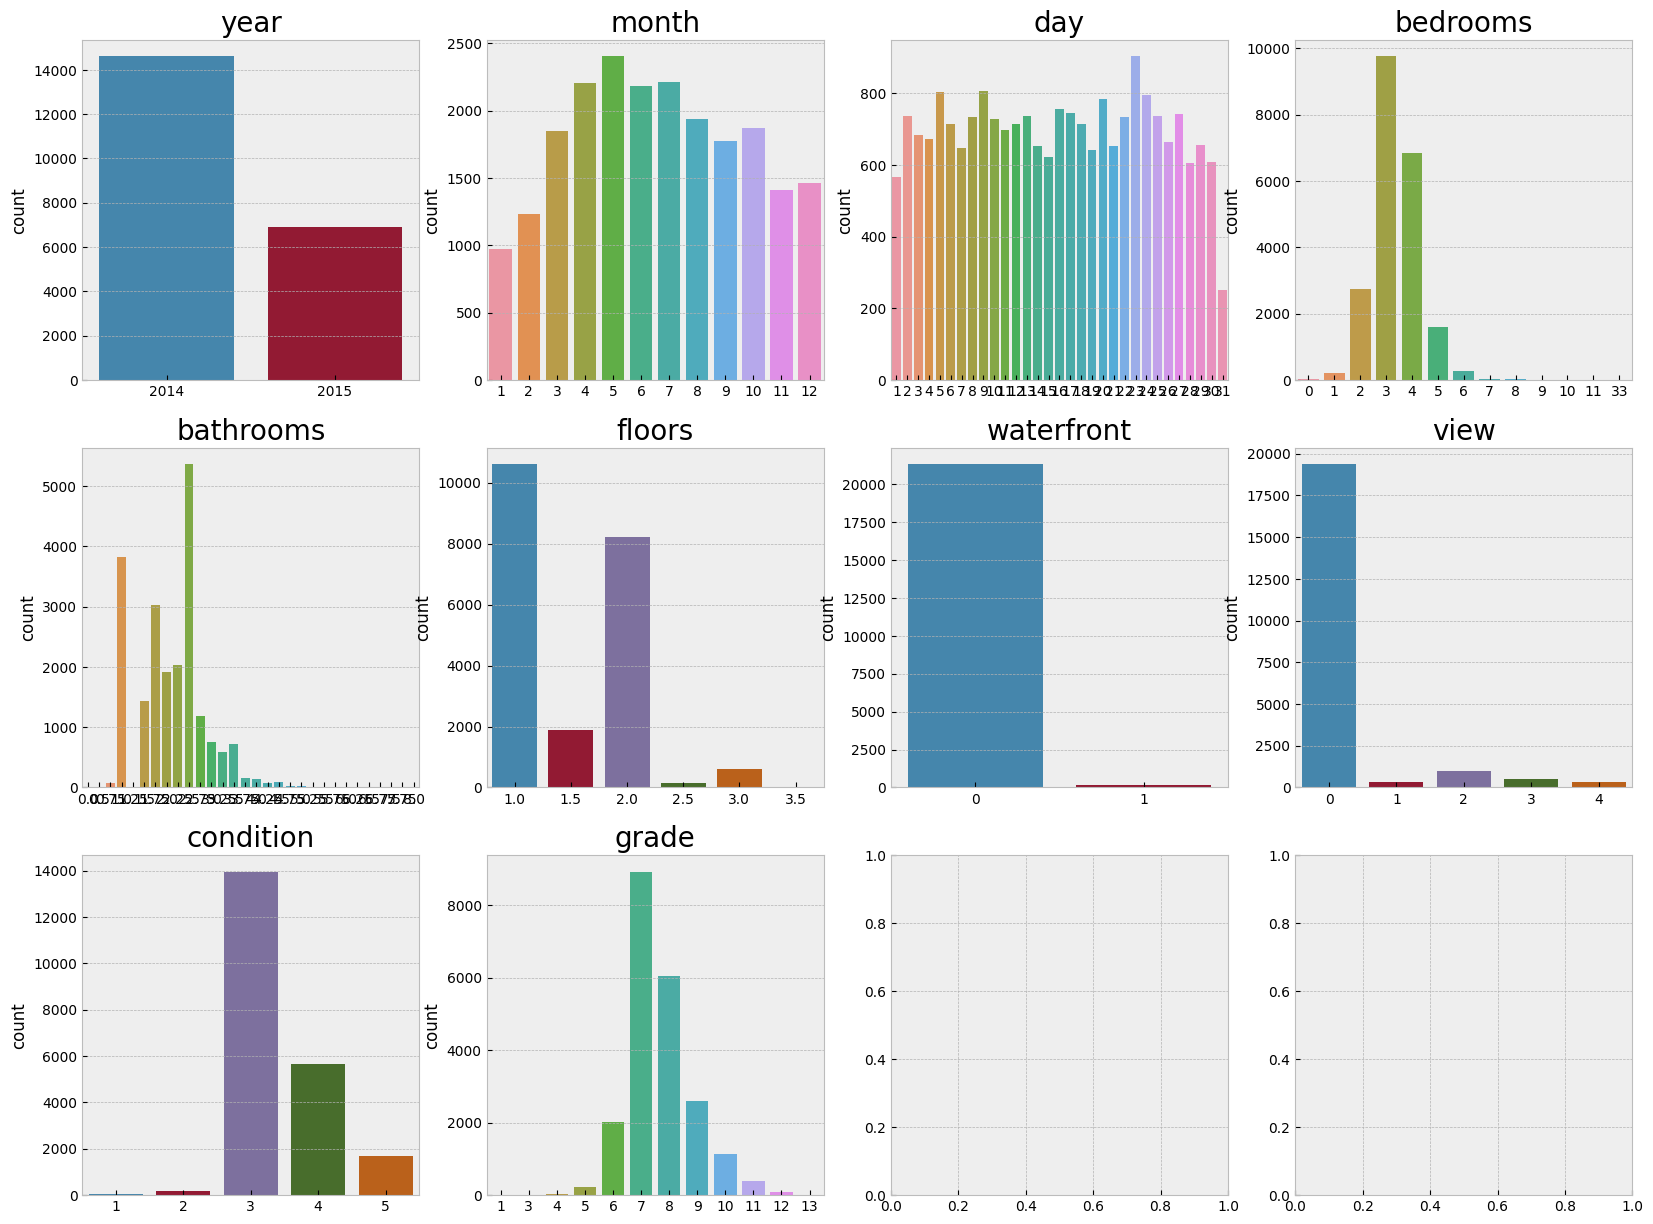

In [16]:
count_info = ['year', 'month', 'day', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for r in range(3):
    for c in range(4):
        index = 4 * r + c
        if index == len(count_info):
            break
        sns.countplot(data=data, x=count_info[index], ax=axes[r, c])
        axes[r, c].set_xlabel('')
        axes[r, c].set_title(count_info[index], fontsize=20)

### 2. Correlation between Discrete Variables

- 데이터는 2014년 5월부터 2015년 5월까지의 집 정보와 가격 정보를 담고 있습니다.
- grade, view, condition에 비례하여 집 가격이 높아지고 있음을 볼 수 있습니다.
- waterfront인지 아닌지에 따른 가격 차이가 존재합니다.
- floors의 소수점은 다락방 등을 의미하는 것으로 보입니다.
- bathrooms는 Taemyung Heo님의 [discussion](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83533)를 참고하면 좋습니다.

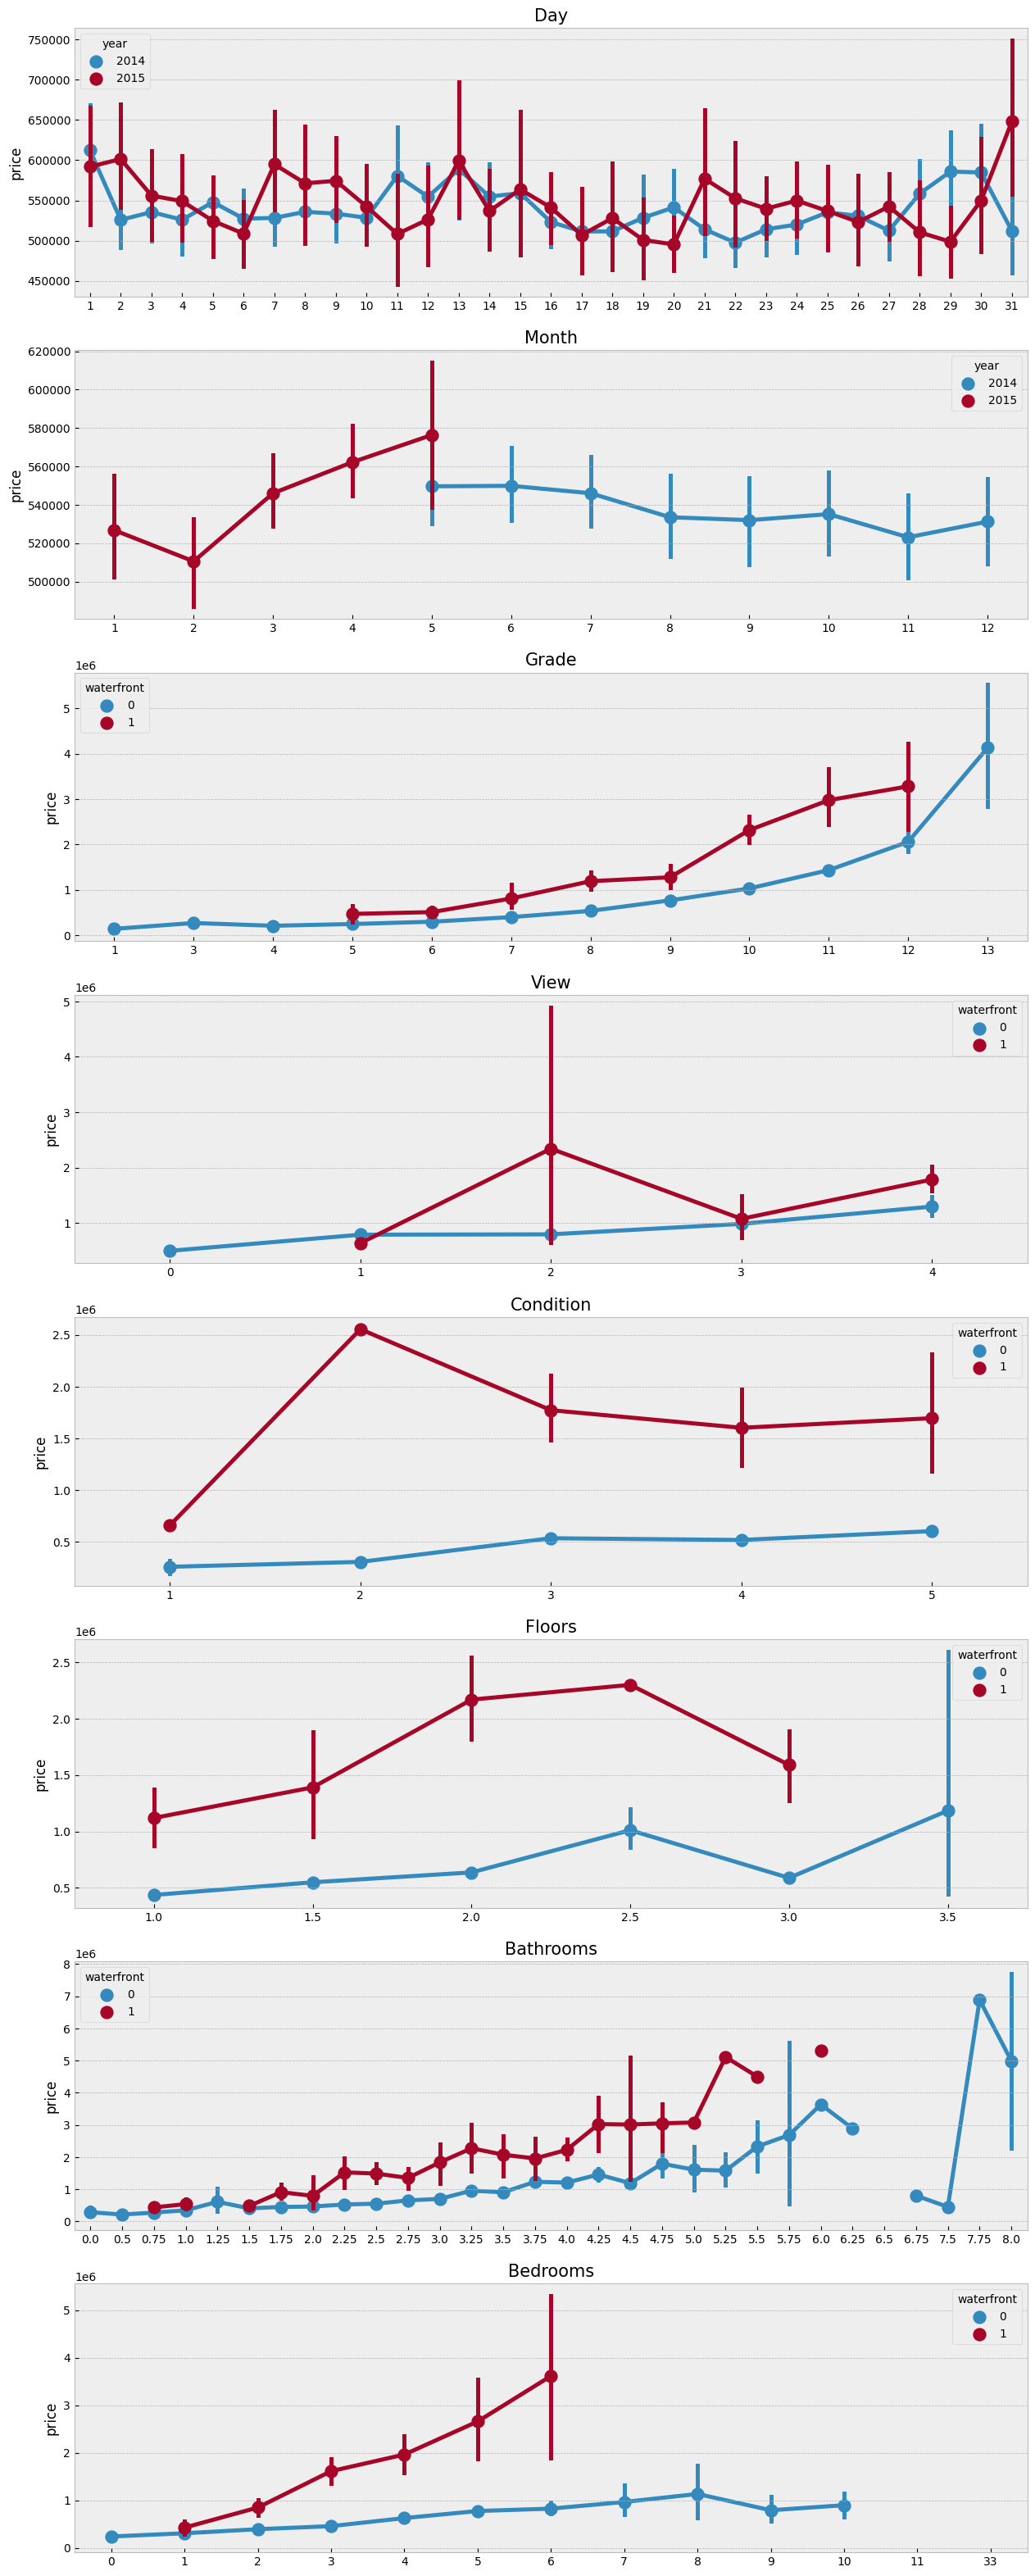

In [17]:
fig, axes = plt.subplots(nrows=8, figsize=(15, 40))

sns.pointplot(data=data, x='day', y='price', hue='year', ax=axes[0])
sns.pointplot(data=data, x='month', y='price', hue='year', ax=axes[1])
sns.pointplot(data=data, x='grade', y='price', hue='waterfront', ax=axes[2])
sns.pointplot(data=data, x='view', y='price', hue='waterfront', ax=axes[3])
sns.pointplot(data=data, x='condition', y='price', hue='waterfront', ax=axes[4])
sns.pointplot(data=data, x='floors', y='price', hue='waterfront', ax=axes[5])
sns.pointplot(data=data, x='bathrooms', y='price', hue='waterfront', ax=axes[6])
sns.pointplot(data=data, x='bedrooms', y='price', hue='waterfront', ax=axes[7])

title = ['Day', 'Month', 'Grade', 'View', 'Condition', 'Floors', 'Bathrooms', 'Bedrooms']
for i in range(8):
    axes[i].set_xlabel('')
    axes[i].set_title(title[i], fontsize=15)
plt.show()

### 3. Correlation between Continuous Variables

- sqft_living은 실질적으로 살 수있는 공간을 뜻합니다.

- sqft_living > sqft_lot인 집이 많은 것으로 보아, sqft_living은 gross floor area로 계산이 되고 있습니다.
    - 만약 어떤 주택의 1층의 면적이 500이고 2층의 면적이 300이라면, sqft_living은 800으로 계산합니다.
    - [참고 링크](https://www.zillow.com/blog/how-to-measure-your-homes-square-footage-92175/)
    - 추가적으로, sqft_living = sqft_above + sqft_basement이며, sqft_basement는 지하실의 면적입니다.
    - sqft_above = 연면적(미국에선 바닥면적)
    - sqft_living을 층 수로 나누어도 여전히 sqft_lot보다 큰 집들이 있습니다.

- 건축 관련 수치들: 
    - 건폐율(building coverage) = 건축면적 / 대지면적
    - 연면적(floor area ratio) = 연면적(바닥면적) / 대지면적

- sqft_lot과 sqft_lot15은 단일 속성으로서 price와 상관관계가 적은 것으로 보입니다.

In [18]:
corrMatt = train[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]
corrMatt = corrMatt.corr()

print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                  price  sqft_living  sqft_lot  sqft_above  sqft_basement  \
price          1.000000     0.702899  0.096793    0.608577       0.322218   
sqft_living    0.702899     1.000000  0.176500    0.878736       0.434017   
sqft_lot       0.096793     0.176500  1.000000    0.186242       0.017818   
sqft_above     0.608577     0.878736  0.186242    1.000000      -0.048623   
sqft_basement  0.322218     0.434017  0.017818   -0.048623       1.000000   
sqft_living15  0.586419     0.760271  0.147562    0.737795       0.198380   
sqft_lot15     0.086384     0.184176  0.728458    0.194226       0.018813   

               sqft_living15  sqft_lot15  
price               0.586419    0.086384  
sqft_living         0.760271    0.184176  
sqft_lot            0.147562    0.728458  
sqft_above          0.737795    0.194226  
sqft_basement       0.198380    0.018813  
sqft_living15       1.000000    0.183599  
sqft_lot15          0.183599    1.000000  


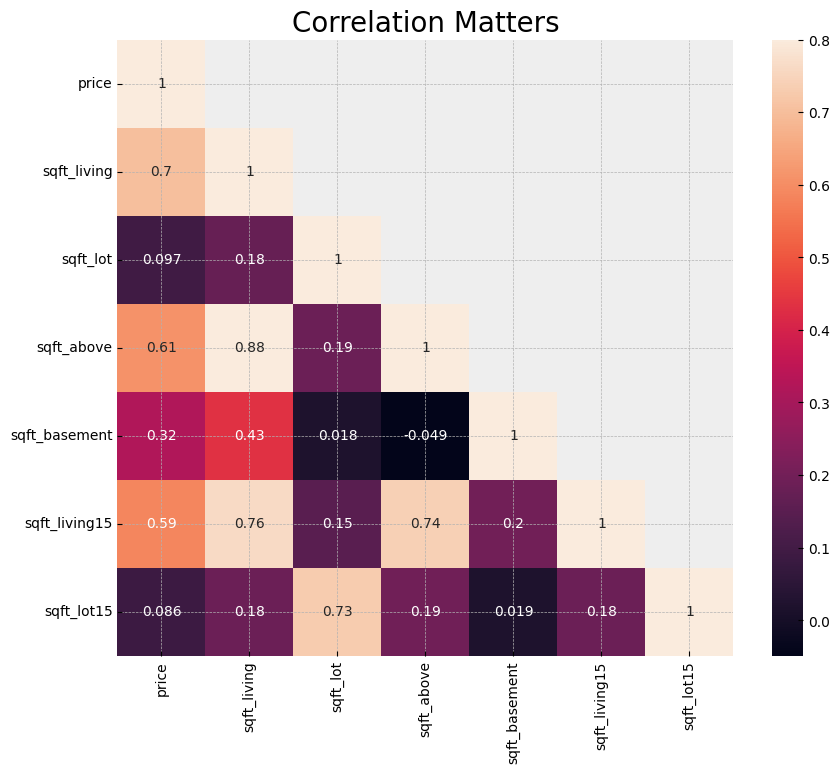

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True)
ax.set_title('Correlation Matters', fontsize=20)
plt.show()

### 4. Distribution of Price

- log scaling(1을 더한 후 log)한 후에 normal distribution에 더욱 가까워지는 것을 확인할 수 있습니다.

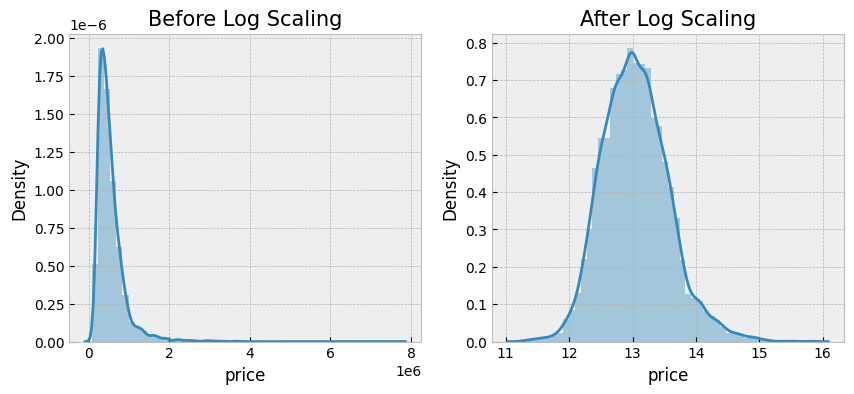

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

sns.distplot(train['price'], ax=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
sns.distplot(np.log1p(train['price']), ax=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

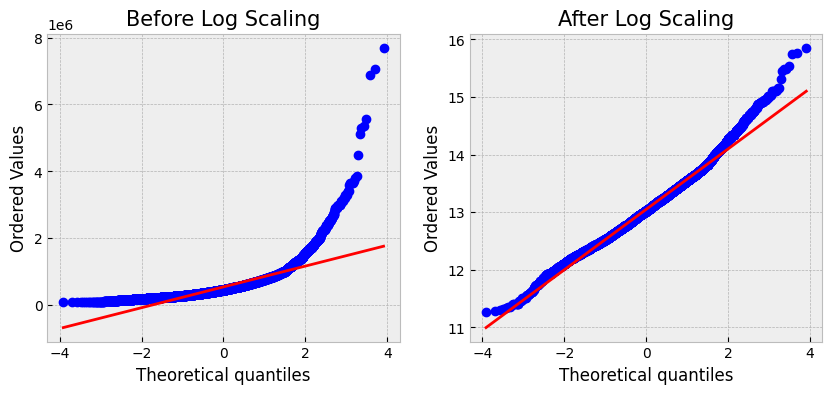

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

reg = stats.probplot(train['price'], plot=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
reg = stats.probplot(np.log1p(train['price']), plot=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

## Preprocessing

- 저 같은 경우에는 이상치를 제거하지 않고 학습을 시행하였습니다.

### 1. Feature Engineering

- 좌표와 가격만을 가지고 clustering하던 중에, __zipcode__를 이용한 __평방 대비 가격(price per footage)__을 다룬 Hyun woo Kim님의 [kernel](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)을 참고하게 되었습니다. 감사드립니다!

- 연도를 쓰지 않고 2014년 5월부터 2015년 5월까지의 시간을 열 세달(1~13)로 쪼개어 재정렬 $\rightarrow$

- 건축 관련 수치 추가
    - floor_area_ratio(sqft_living / sqft_lot) 추가 $\rightarrow$ 성능 상승
    - building_coverage(sqft_above / (floor * sqft_lot)) 추가 $\rightarrow$ 효과 없었음
    - 그 외 여러가지 시도
 
- 지하실 유무, 다락방 유무, 재건축 유무 등에 대한 feature를 추가할 수도 있으나 효과 없었음
    - feature의 개수가 많아져서 model complexity가 증가하면 overfitting이 강력해지기 때문으로 추측
    
- 방 관련 feature 추가
    - 방 총 개수 추가 $\rightarrow$ 효과 없었음
    
- sqft_lot15 제거 $\rightarrow$ **상황마다 다른 걸로 결론**

- how_old: 건물이 건축되고 리모델링 된 후, 팔리기까지 걸린 시간

- yr_renovated 제거

### 2. Log Scaling

- 평방 관련 수치에 대해 log scaling

### 3. Label Encoding

- zipcode에 Label Encoding
- yr_built = yr_built - 1900 적용

zipcode 레이블 인코딩

In [22]:
le = LabelEncoder()
le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

평방대비가격 변수 추가

In [23]:
train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()

train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')

del train['price_per_land_area']

In [24]:
X_train = train.drop(['id', 'price'], axis=1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id'], axis=1)

In [26]:
# Adding features
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)  # 연도를 쓰지 않고 시간을 재정렬
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1)   # 건물 나이
    del df['date']
    del df['yr_renovated']
    df['yr_built'] = df['yr_built'] - 1900
    df['sqft_floor'] = df['sqft_above'] / df['floors']
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15']

변수 로그 변환

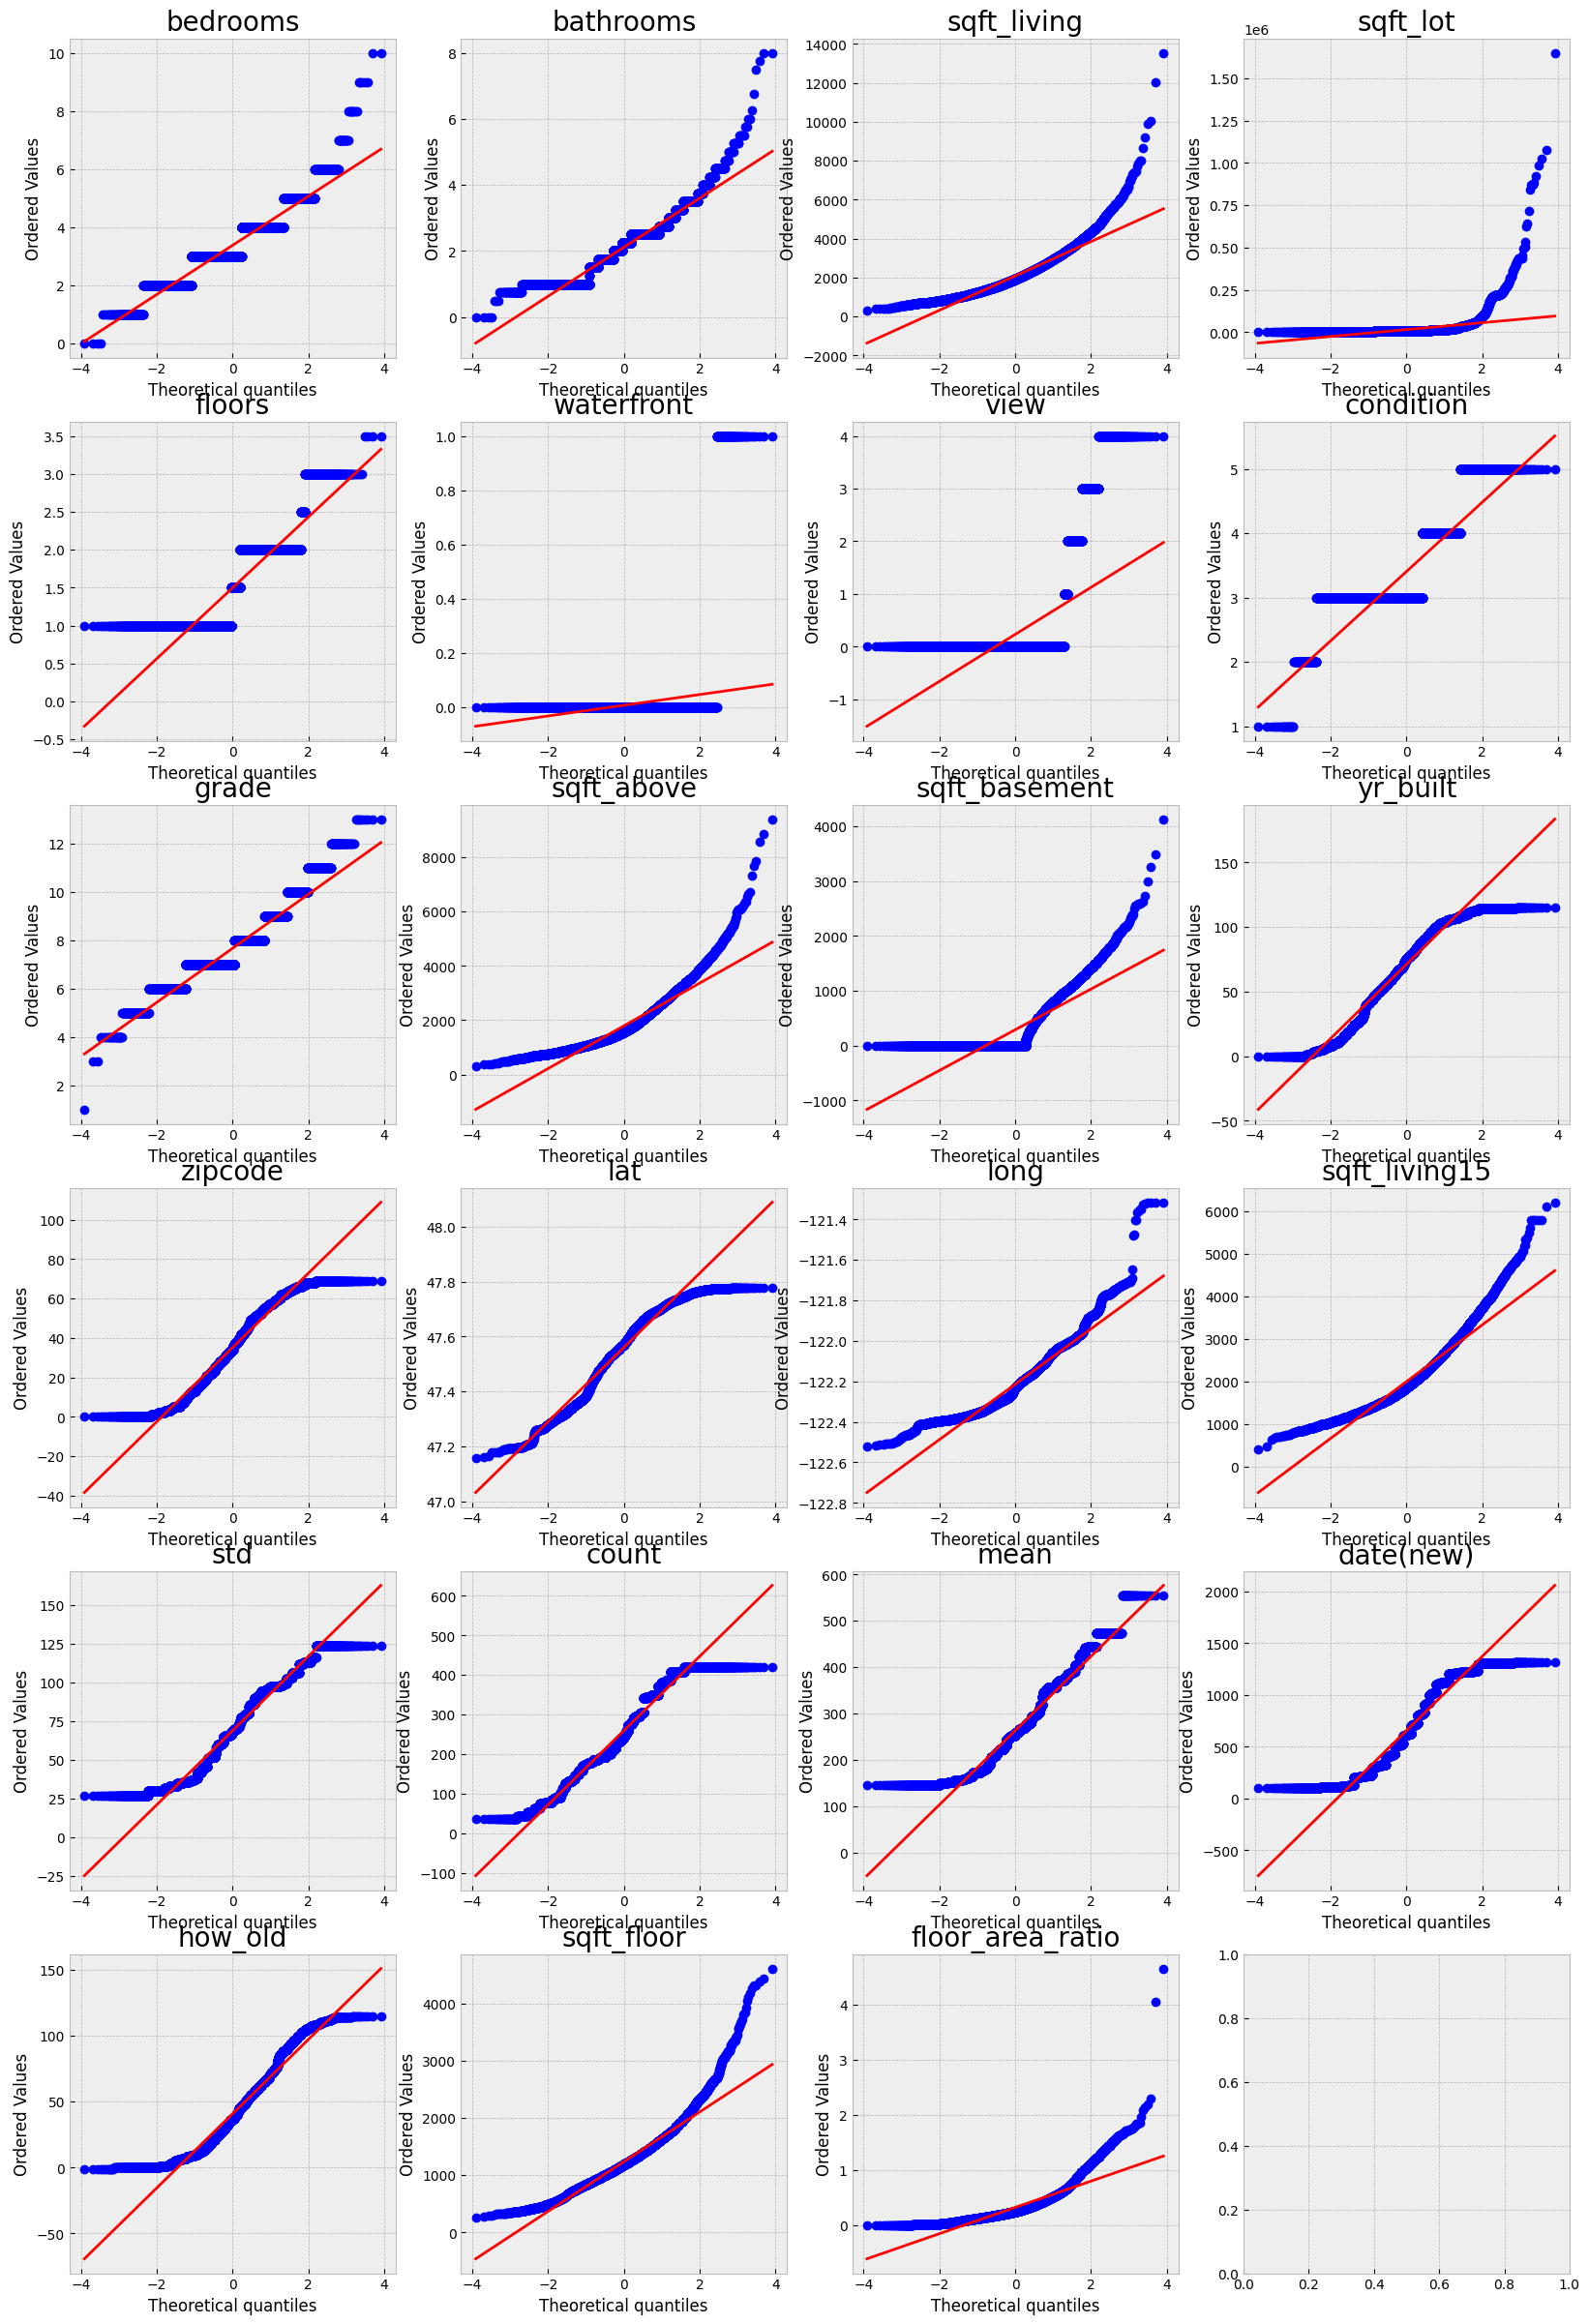

In [27]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

In [28]:
# Log Scaling
log_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_floor', 'mean', 'floor_area_ratio', 'floor_area_ratio']
for feature in log_features:
    for df in [X_train, X_test]:
        df[feature] = np.log1p(df[feature])

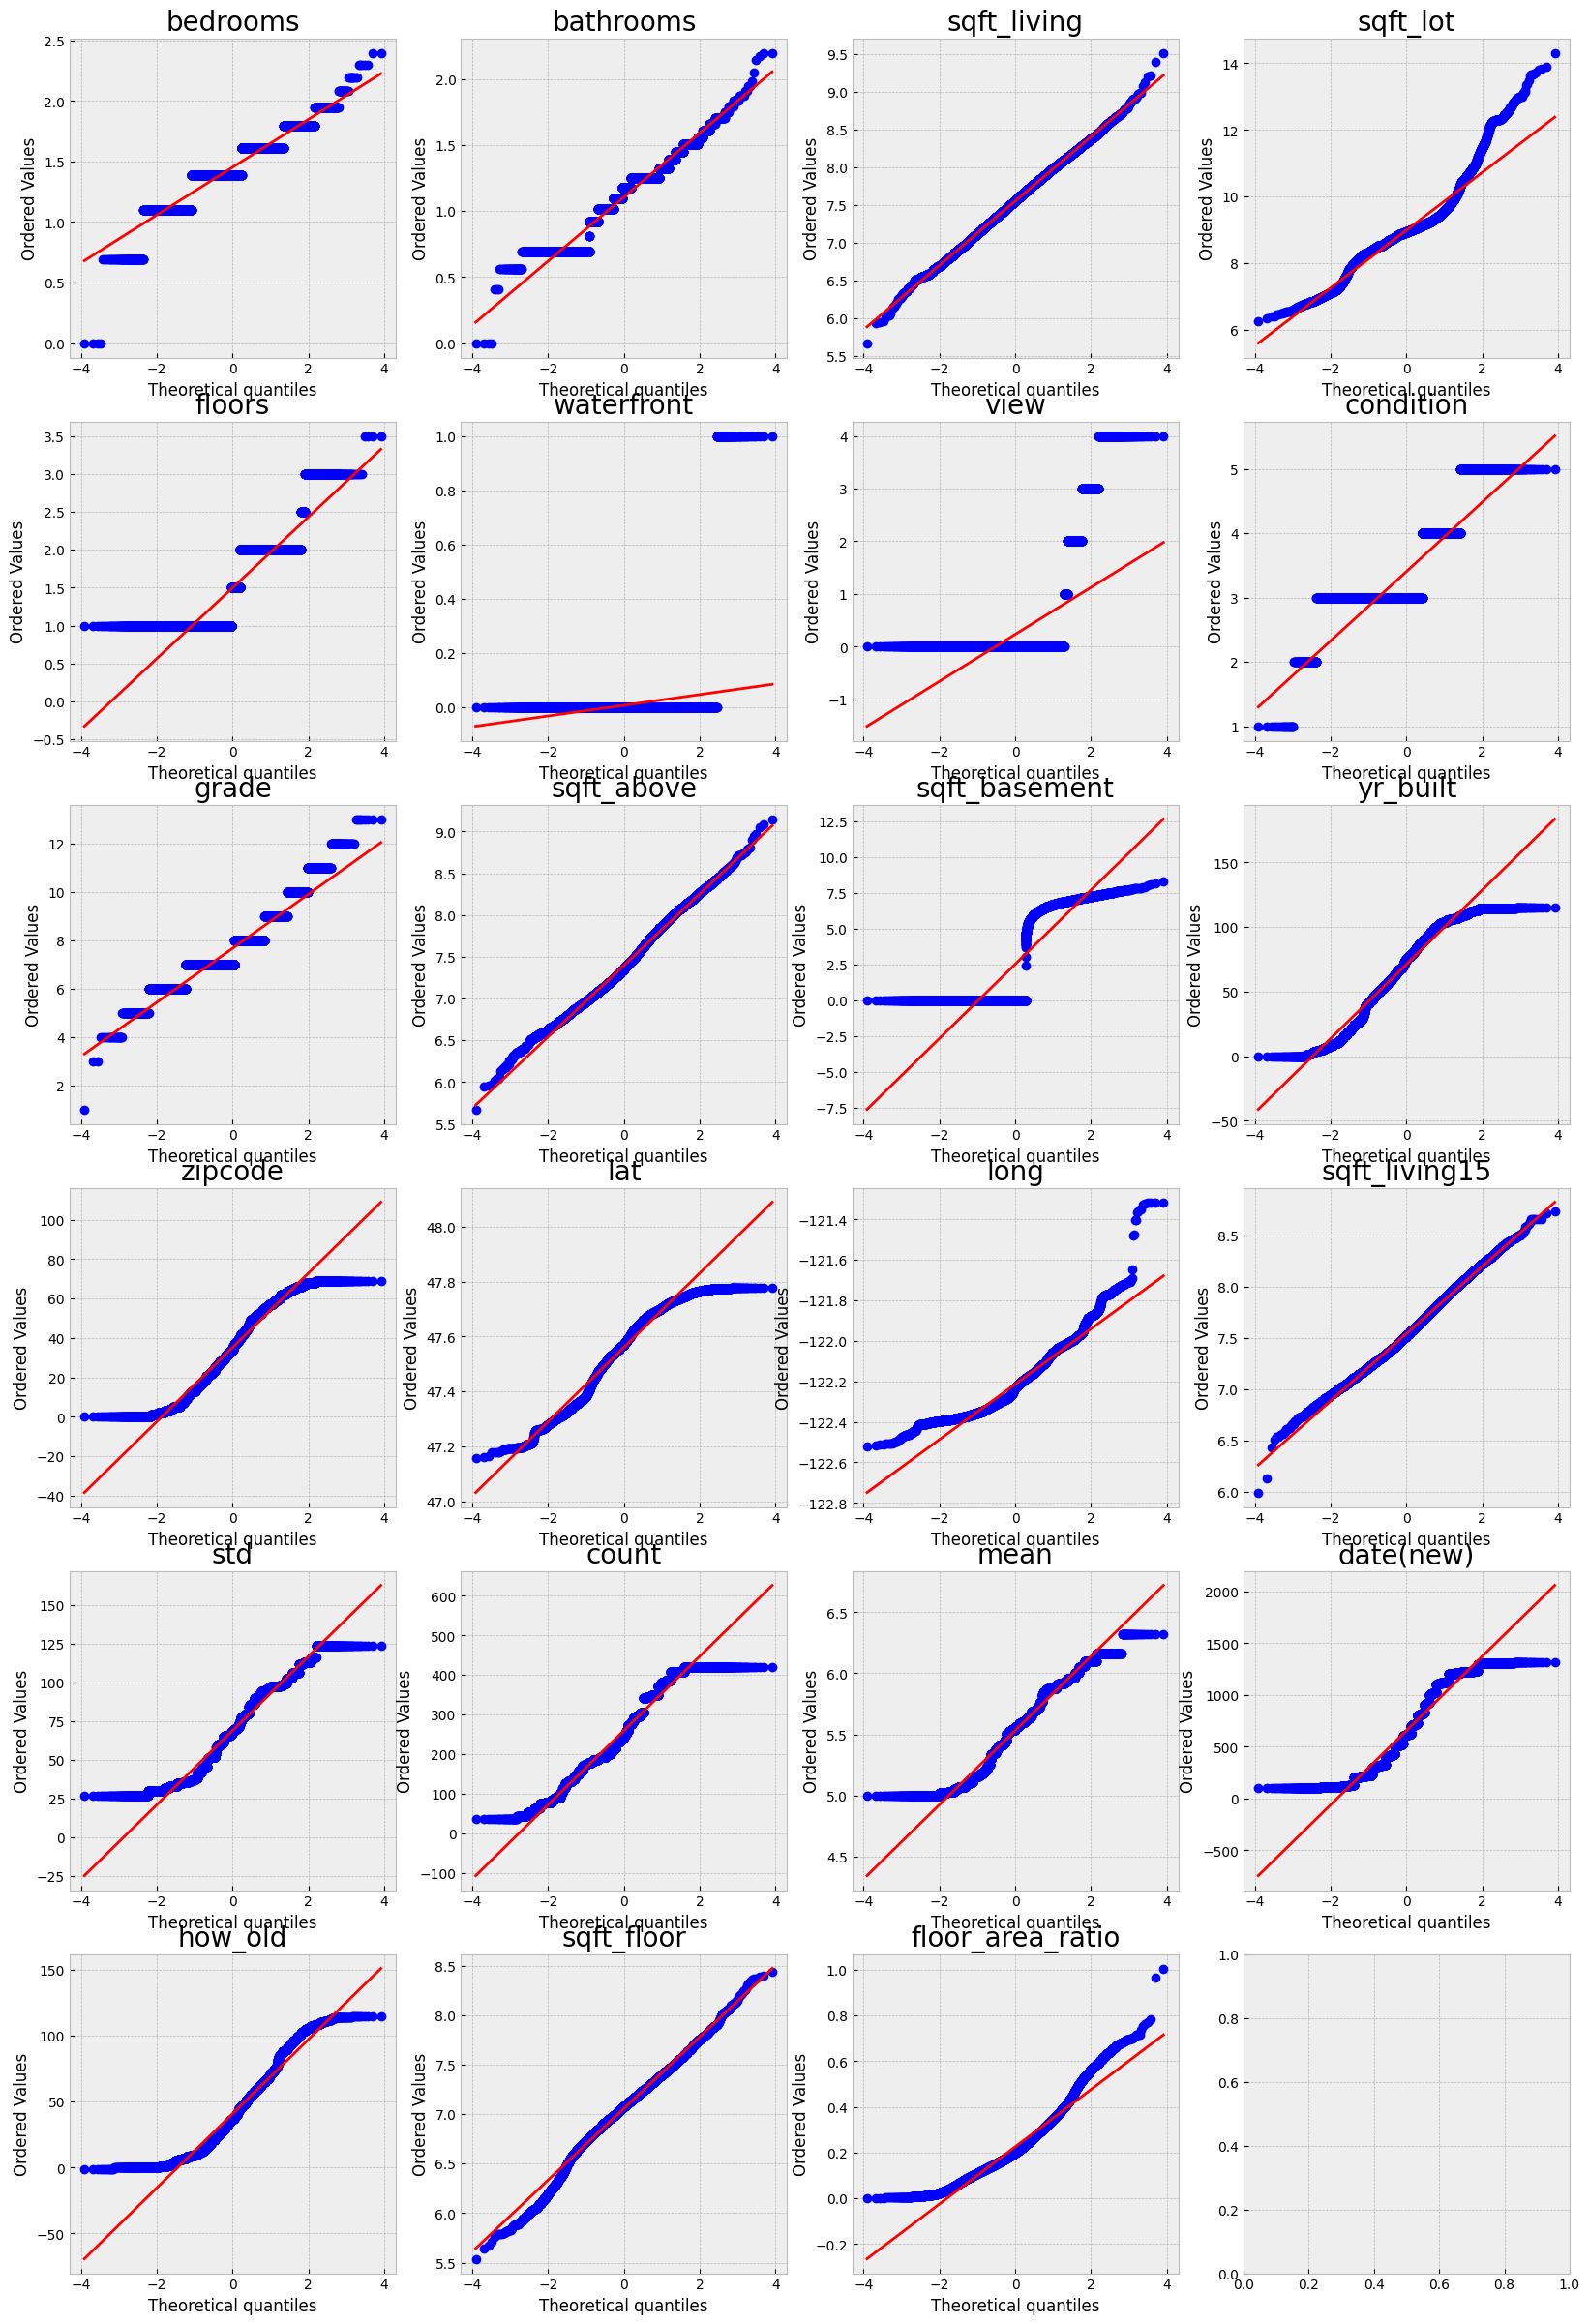

In [29]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

## Learning

- xgboost 하나의 모델만을 이용해 학습해보겠습니다.
- 평가 척도는 RMSE(Root Mean Square Error)이며, 수식은 다음과 같습니다.
$$
RMSE(y, \bar{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \bar{y}_i)^2}
$$
where $y=(y_1, y_2, \ldots, y_n)$ and $\bar{y}=(\bar{y}_1, \bar{y}_2, \ldots, \bar{y}_n)$ denote the vector of actual values and the vector of our predicted values, respectively.

In [30]:
# feval function에 사용하기 위해
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    error = np.expm1(predictions) - np.expm1(labels)
    squared_error = np.square(error)
    mean = np.mean(squared_error)
    return ('rmse_exp', np.sqrt(mean))

### 1. Hyperparameter

- 튜닝에는 Grid Search를 이용하였습니다.

In [31]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
#     'tree_method': 'gpu_hist',    # 최적화된 분할 지점을 찾기 위한 algorithm 설정 + 캐글의 GPU 사용
#     'predictor': 'gpu_predictor', # 예측 시에도 GPU사용
    'objective': 'reg:linear',    # 회귀
    'eval_metric': 'rmse',        # kaggle에서 요구하는 검증모델
    'silent': True,               # 학습 동안 메세지 출력할지 말지
    'seed': 4777,
}

### 2. Validation

- 우리는 price 대신 $\log(\text{price}+1)$을 사용했으므로, scoring을 할 때 feval function을 이용하여 $\exp(\bar{y})-1$를 취해줍니다.

[10:16:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:16:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:16:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:16:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:16:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:16:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:16:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:16:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:16:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:16:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } 

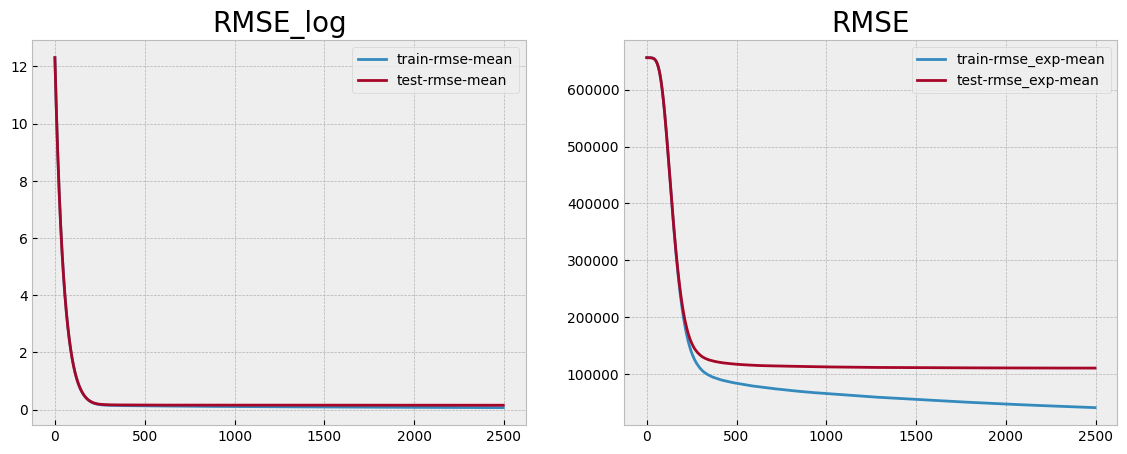

CPU times: user 7min 1s, sys: 2.63 s, total: 7min 4s
Wall time: 4min 8s


In [32]:
%%time
# transforming
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         # the number of boosting trees
                   early_stopping_rounds=100,    # val loss가 계속 상승하면 중지
                   nfold=5,                      # set folds of the closs validation
                   verbose_eval=100,             # 몇 번째마다 메세지를 출력할 것인지
                   feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')


# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()

### 3. Prediction

- 마찬가지로 예측값에도 $\exp(\bar{y})-1$를 취해줍니다.

In [33]:
model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
y_pred = model.predict(dtest)
y_pred = np.expm1(y_pred)

[10:21:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



### 4. Feature Importance

- waterfront는 feature importance가 낮은데도 불구하고 시각화나 실험단계에서 집 가격에 상당한 영향을 미치는 것을 확인하였는데, 이는 waterfront인 집과 아닌 집의 수 차이가 많이 나기 때문으로 생각합니다.
- EDA에서 sqft_lot 속성은 price와 낮은 관계성을 보였는데, feature importance에서는 굉장히 높은 중요도를 띕니다.

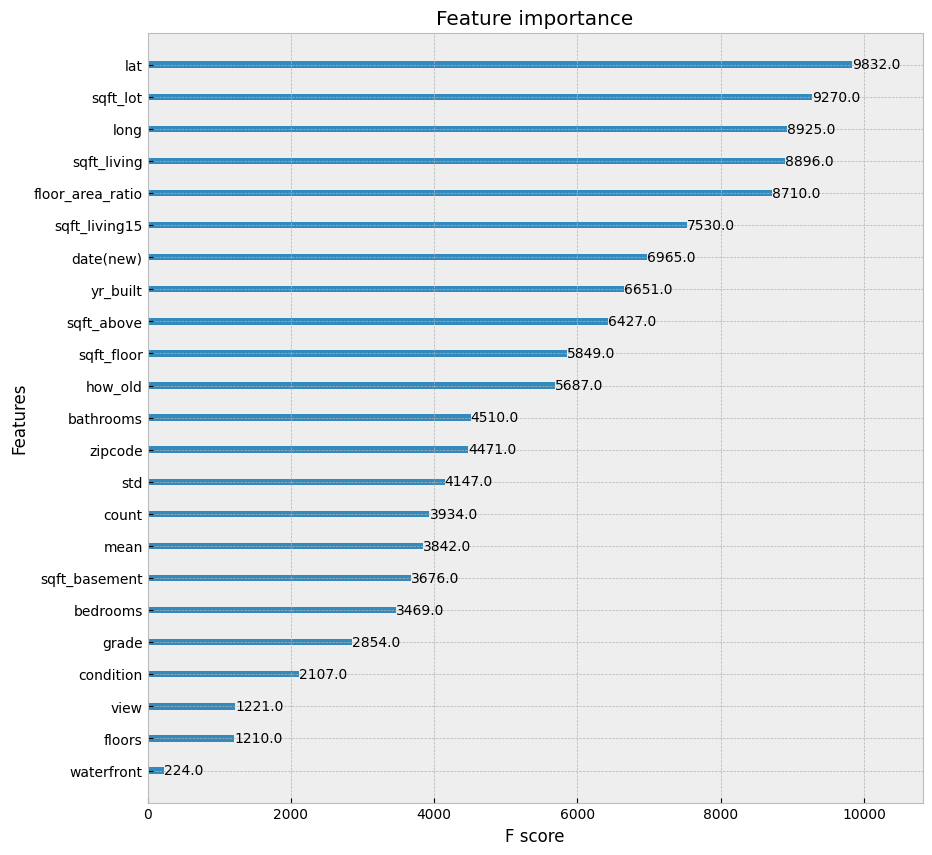

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

plt.show()

- Shap 라이브러리를 이용하여 각 Feature마다 회귀에 어떻게 영향을 주는지 확인합니다.
- 주의: 현재 Shap 라이브러리와 GPU를 함께 사용하면 kernel이 꺼지는 현상이 발생합니다. Shap를 사용하지 않고 parameter 단계에서 주석처리된 tree_method를 활성화시키면 GPU를 사용할 수 있습니다.

## Submission

- submission sample를 확인하고 그 양식에 맞게 submission 파일을 만들어 제출합니다.

In [36]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/aiffel/data/house pricing 2019/sample_submission.csv')

print(sample_submission.shape)
sample_submission.head()

(6468, 2)


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [37]:
submission = pd.DataFrame(data = {'id': test['id'], 'price': y_pred})

print(submission.shape)
submission.head()

(6468, 2)


,id,price
0,15035,5.370328e+05
1,15036,4.878177e+05
2,15037,1.402584e+06
3,15038,3.074222e+05
4,15039,3.239516e+05


In [39]:
submission.to_csv('xgbonly.csv', index=False)

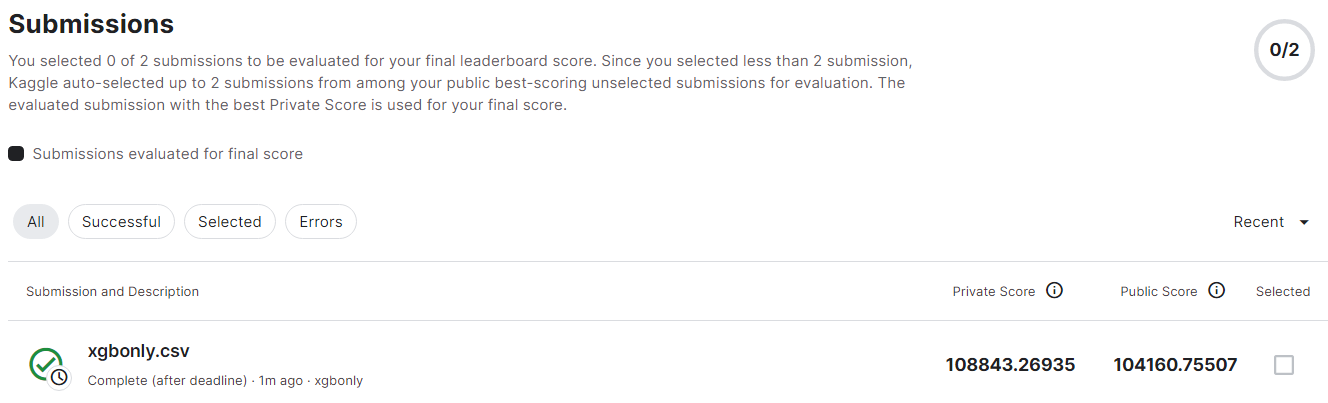